In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch

import plotnine
from plotnine import *

dpi = 300

In [2]:
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220316_SpaceJam_UKCIC36Donor/'
result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_33experiments_62clusters_233locations_10276genes_33Donor6Patho_geneE-6_cellE6/'
adata_vis=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

### Figure 3A

In [3]:
cross = pd.crosstab(index=adata_vis.obs.Pathology, 
                             columns=adata_vis.obs.Donor_AltName,
                             margins=False)

In [4]:
cross=cross.stack().reset_index().rename(columns={ 0:'n_ROIs'})
cross=cross[[cross.iloc[c]['n_ROIs'] != 0 for c in range(len(cross)) ]]
cross=cross[[cross.iloc[c]['Pathology'] not in ['ACFF', 'BRON'] for c in range(len(cross)) ]]

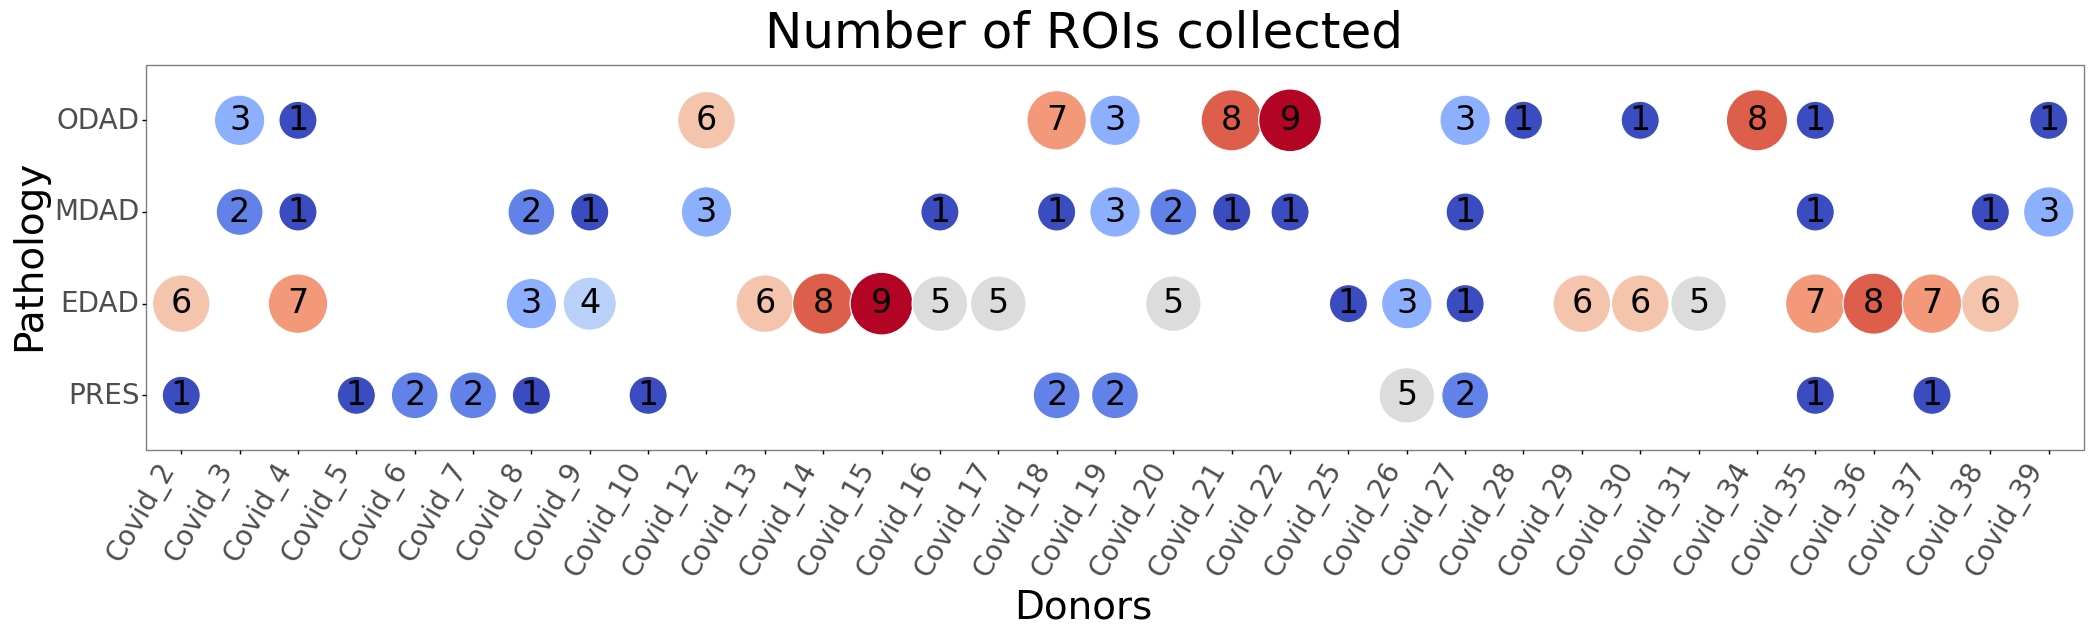

<ggplot: (8745914480133)>

In [5]:
plotnine.options.figure_size=(5,30)

# p1=(
#     ggplot() +
#     geom_point(data=cross, mapping=aes(y = "Donor_AltName", x = "Pathology", fill = "n_ROIs", size = 'n_ROIs'))+ 
#     geom_text(data=cross,mapping=aes(y = "Donor_AltName", x = "Pathology", label = "n_ROIs"), size=24)  + 
#     theme_bw() +
#     theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=12), 
#           axis_text_y = element_text(size=16), 
#           axis_title_x= element_text(size=16), 
#           axis_title_y= element_text(size=16), 
#           legend_position=None ) + 
#     scale_size_continuous(range=[15,20]) +
#     scale_fill_distiller(palette = "RdPu") +
#     ylab("Donors") + xlab("Pathology")



# )
# p1


plotnine.options.figure_size=(25,5)
plotnine.dpi = dpi

p1=(
    ggplot() +
    geom_point(data=cross, mapping=aes(x = "Donor_AltName", y = "Pathology", fill = "n_ROIs", size = "n_ROIs"), colour = "white")+ 
    geom_text(data=cross,mapping=aes(x = "Donor_AltName", y = "Pathology", label = "n_ROIs"), size=24)  + 
    theme_bw() +
    theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20), 
          axis_text_y = element_text(size=20),
          title = element_text(size=36), 
          axis_title_x = element_text(size=28), 
          axis_title_y = element_text(size=28), 
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          legend_position = "none" ) + 
    scale_size_continuous(range=[15,25]) +
    scale_y_discrete(limits=["PRES", "EDAD", "MDAD", "ODAD"]) +
    scale_fill_cmap(cmap_name="coolwarm" ) +
    xlab("Donors") + ylab("Pathology") + ggtitle("Number of ROIs collected")



)
p1

### Figure 3Db

In [6]:
gene_list_rf=pd.read_csv('/home/jovyan/projects/nanostring-covid/data/jae-won/random_forest_all_sample_var1000_importance.csv', sep=',', index_col=0)
gene_list_rf['gene']=gene_list_rf.index
gene_list_rf=gene_list_rf[gene_list_rf.gene != "BAGE5" ] # not availabe in sc/sn data
selected_top20_markers = gene_list_rf.iloc[0:19]

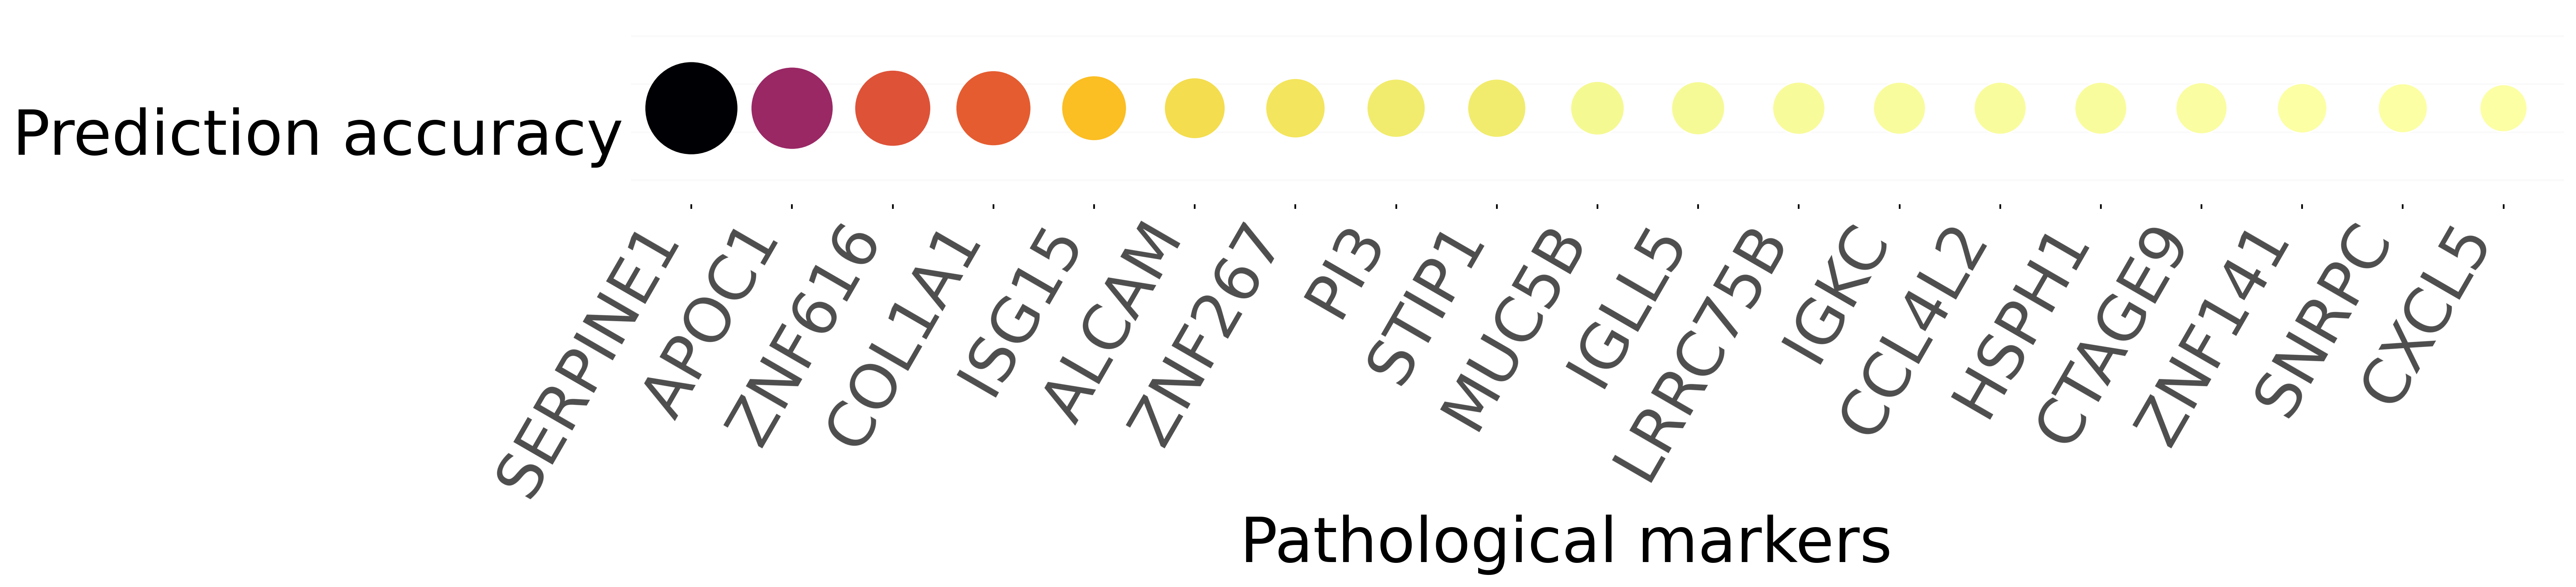

<ggplot: (8745915072945)>

In [7]:
plotnine.options.figure_size=(20,2)
plotnine.options.dpi = dpi

p1 = (
    ggplot() + 
    geom_point( data = selected_top20_markers, mapping = aes( x = "reorder(gene, -x)", y = "1", fill = "x", size = "x"), colour = "white") +
    theme_bw() +
    theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=36), 
          axis_text_y = element_blank(), 
          axis_title_y = element_text(angle = 0, vjust = 1, hjust = 1),
          title= element_text(size = 36),
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          panel_border = element_blank(),
          axis_ticks_major_y = element_blank(),
          legend_position = "none" ) + 
    scale_size_continuous(range=[15,30]) +
    scale_fill_cmap(cmap_name = "inferno_r") +
    xlab("Pathological markers") + ylab("Prediction accuracy") 
)

p1

### Figure 3E

In [8]:
path = '/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/20220202_WTA/'
sp_adata = sc.read_h5ad(f"{path}finalRun_geneProbeCounts_AnnData_CC-SimpleCorrected_Filtered_UKCIC-Lung_4Patho.h5ad")

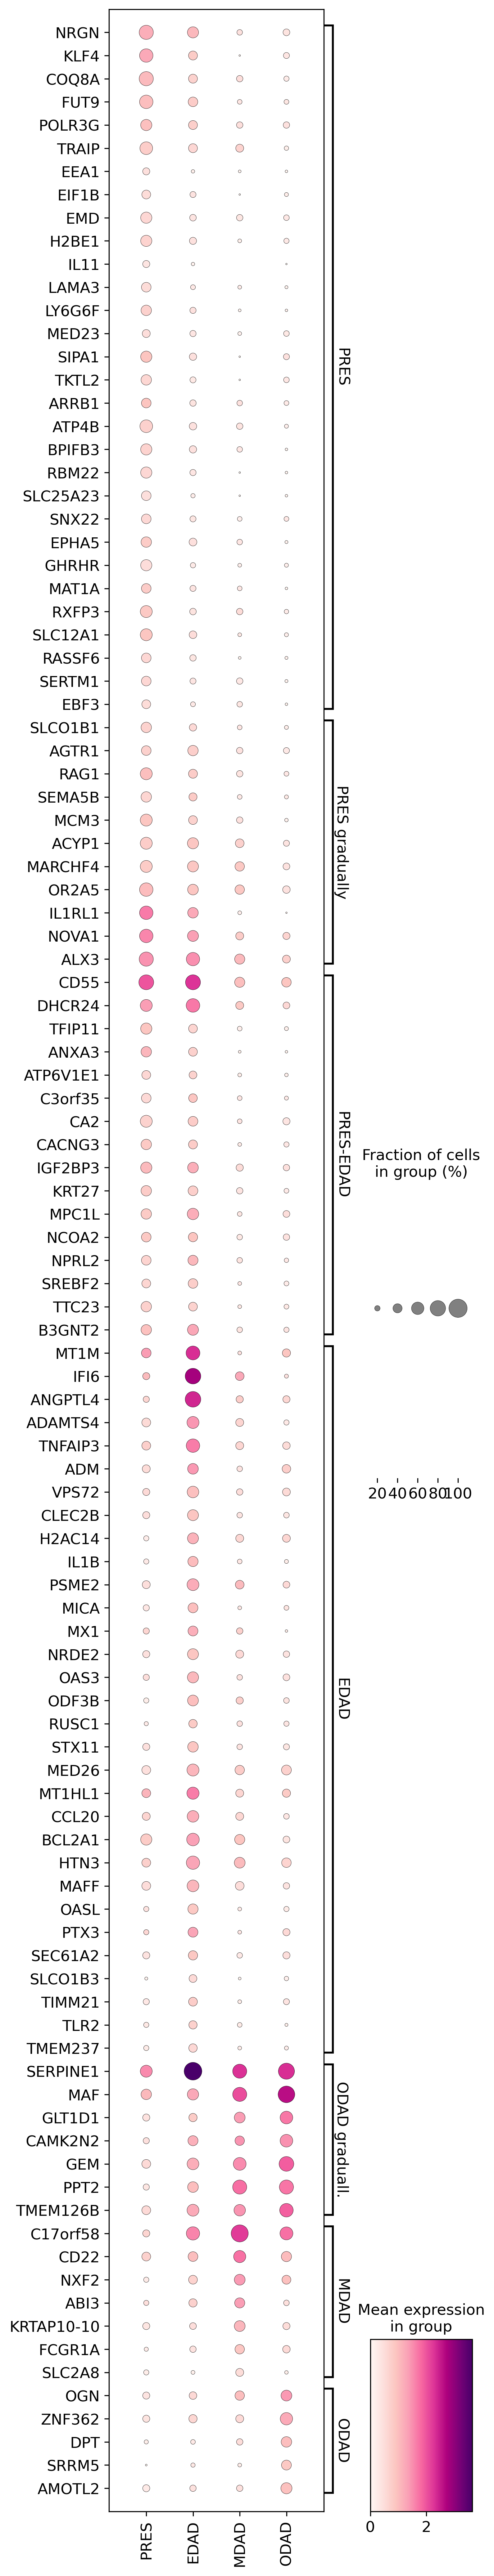

In [9]:
sc.set_figure_params(scanpy=True, fontsize=14, dpi = dpi) 

subset_features = {
#     "PRES only" : ["CYP3A5", "CYP4A22", "DCBLD1", "DLK1", "DUS2", "HES5","LRSAM1" ],
    "PRES": [ "NRGN","KLF4", "COQ8A", "FUT9","POLR3G", "TRAIP","EEA1", "EIF1B", "EMD", "H2BE1","IL11", "LAMA3", "LY6G6F", "MED23", "SIPA1", "TKTL2", "ARRB1", "ATP4B", "BPIFB3", "RBM22", "SLC25A23", "SNX22", "EPHA5", "GHRHR", "MAT1A", "RXFP3", "SLC12A1", "RASSF6", "SERTM1", "EBF3"], #PRES
#     "PRES weak" : ["PROK2", "AKR1C3", "ALS2", "ANO10", "ARHGEF12", "CACNA1A", "CAND2", "CASR", "CXCR5", "CYB5R2", "DDR1", "DENND2D", "DMRTA1", "EDNRB", "EPGN", "EPM2A", "FCMR", "FIGLA", "FLRT2", "FRMD3", "IGSF10", "JMJD1C", "MCPH1", "OR8I2", "POLR2C", "ZAN", "ZDHHC19", "KCNV2", "ROBO4", "SESTD1", "TFR2"], #PRES weak
    "PRES gradually" : ["SLCO1B1", "AGTR1",  "RAG1", "SEMA5B", "MCM3","ACYP1","MARCHF4", "OR2A5","IL1RL1","NOVA1","ALX3" ], # PRESGradually strong
#     "PRES gradually_weak" : ["TMEM60", "ATP7A", "AMN1", "DCAF12L2", "DIPK1A", "EFCAB7", "EFNA4", "FRK", "HSD11B1L", "ING5", "JUP", "KCNC1", "PRR16", "TMEM82", "AP3M2", "APOBEC3A",  "C8A", "CD58",  "PSMC4", "PTH", "SEMG1", "SERPINB11"], # PRESGradually weak
    "PRES-EDAD" : ["CD55", "DHCR24", "TFIP11", "ANXA3", "ATP6V1E1", "C3orf35", "CA2", "CACNG3",  "IGF2BP3", "KRT27", "MPC1L", "NCOA2", "NPRL2", "SREBF2", "TTC23", "B3GNT2"], #PRES EDAD
#     "EDAD weak": ["SASS6", "TNR", "TRIM37", "DLX6", "C18orf54", "CATSPERE", "CCDC105", "CSMD1","MED21", "RET"], #EDAD weak
    "EDAD" : ["MT1M","IFI6", "ANGPTL4", "ADAMTS4", "TNFAIP3", "ADM", "VPS72", "CLEC2B", "H2AC14", "IL1B", "PSME2",  "MICA", "MX1", "NRDE2", "OAS3", "ODF3B", "RUSC1", "STX11", "MED26",  "MT1HL1","CCL20","BCL2A1",  "HTN3",   "MAFF",  "OASL", "PTX3", "SEC61A2", "SLCO1B3", "TIMM21", "TLR2", "TMEM237"], #EDAD 
    "ODAD gradually" : ["SERPINE1", "MAF", "GLT1D1", "CAMK2N2", "GEM", "PPT2", "TMEM126B"],  #ODAD gradually
    "MDAD" : ["C17orf58", "CD22", "NXF2","ABI3", "KRTAP10-10", "FCGR1A", "SLC2A8"], #MDAD
    "ODAD" : ["OGN","ZNF362", "DPT", "SRRM5",  "AMOTL2"] #ODAD
}

sc.pl.dotplot(adata=sp_adata, var_names = subset_features,
              groupby="Pathology", categories_order = ["PRES", "EDAD", "MDAD", "ODAD"], swap_axes=True,
              dendrogram=False, figsize=[5, 35], log = True, layer = "X_cc_corrected", 
              mean_only_expressed = False,
              cmap='RdPu')

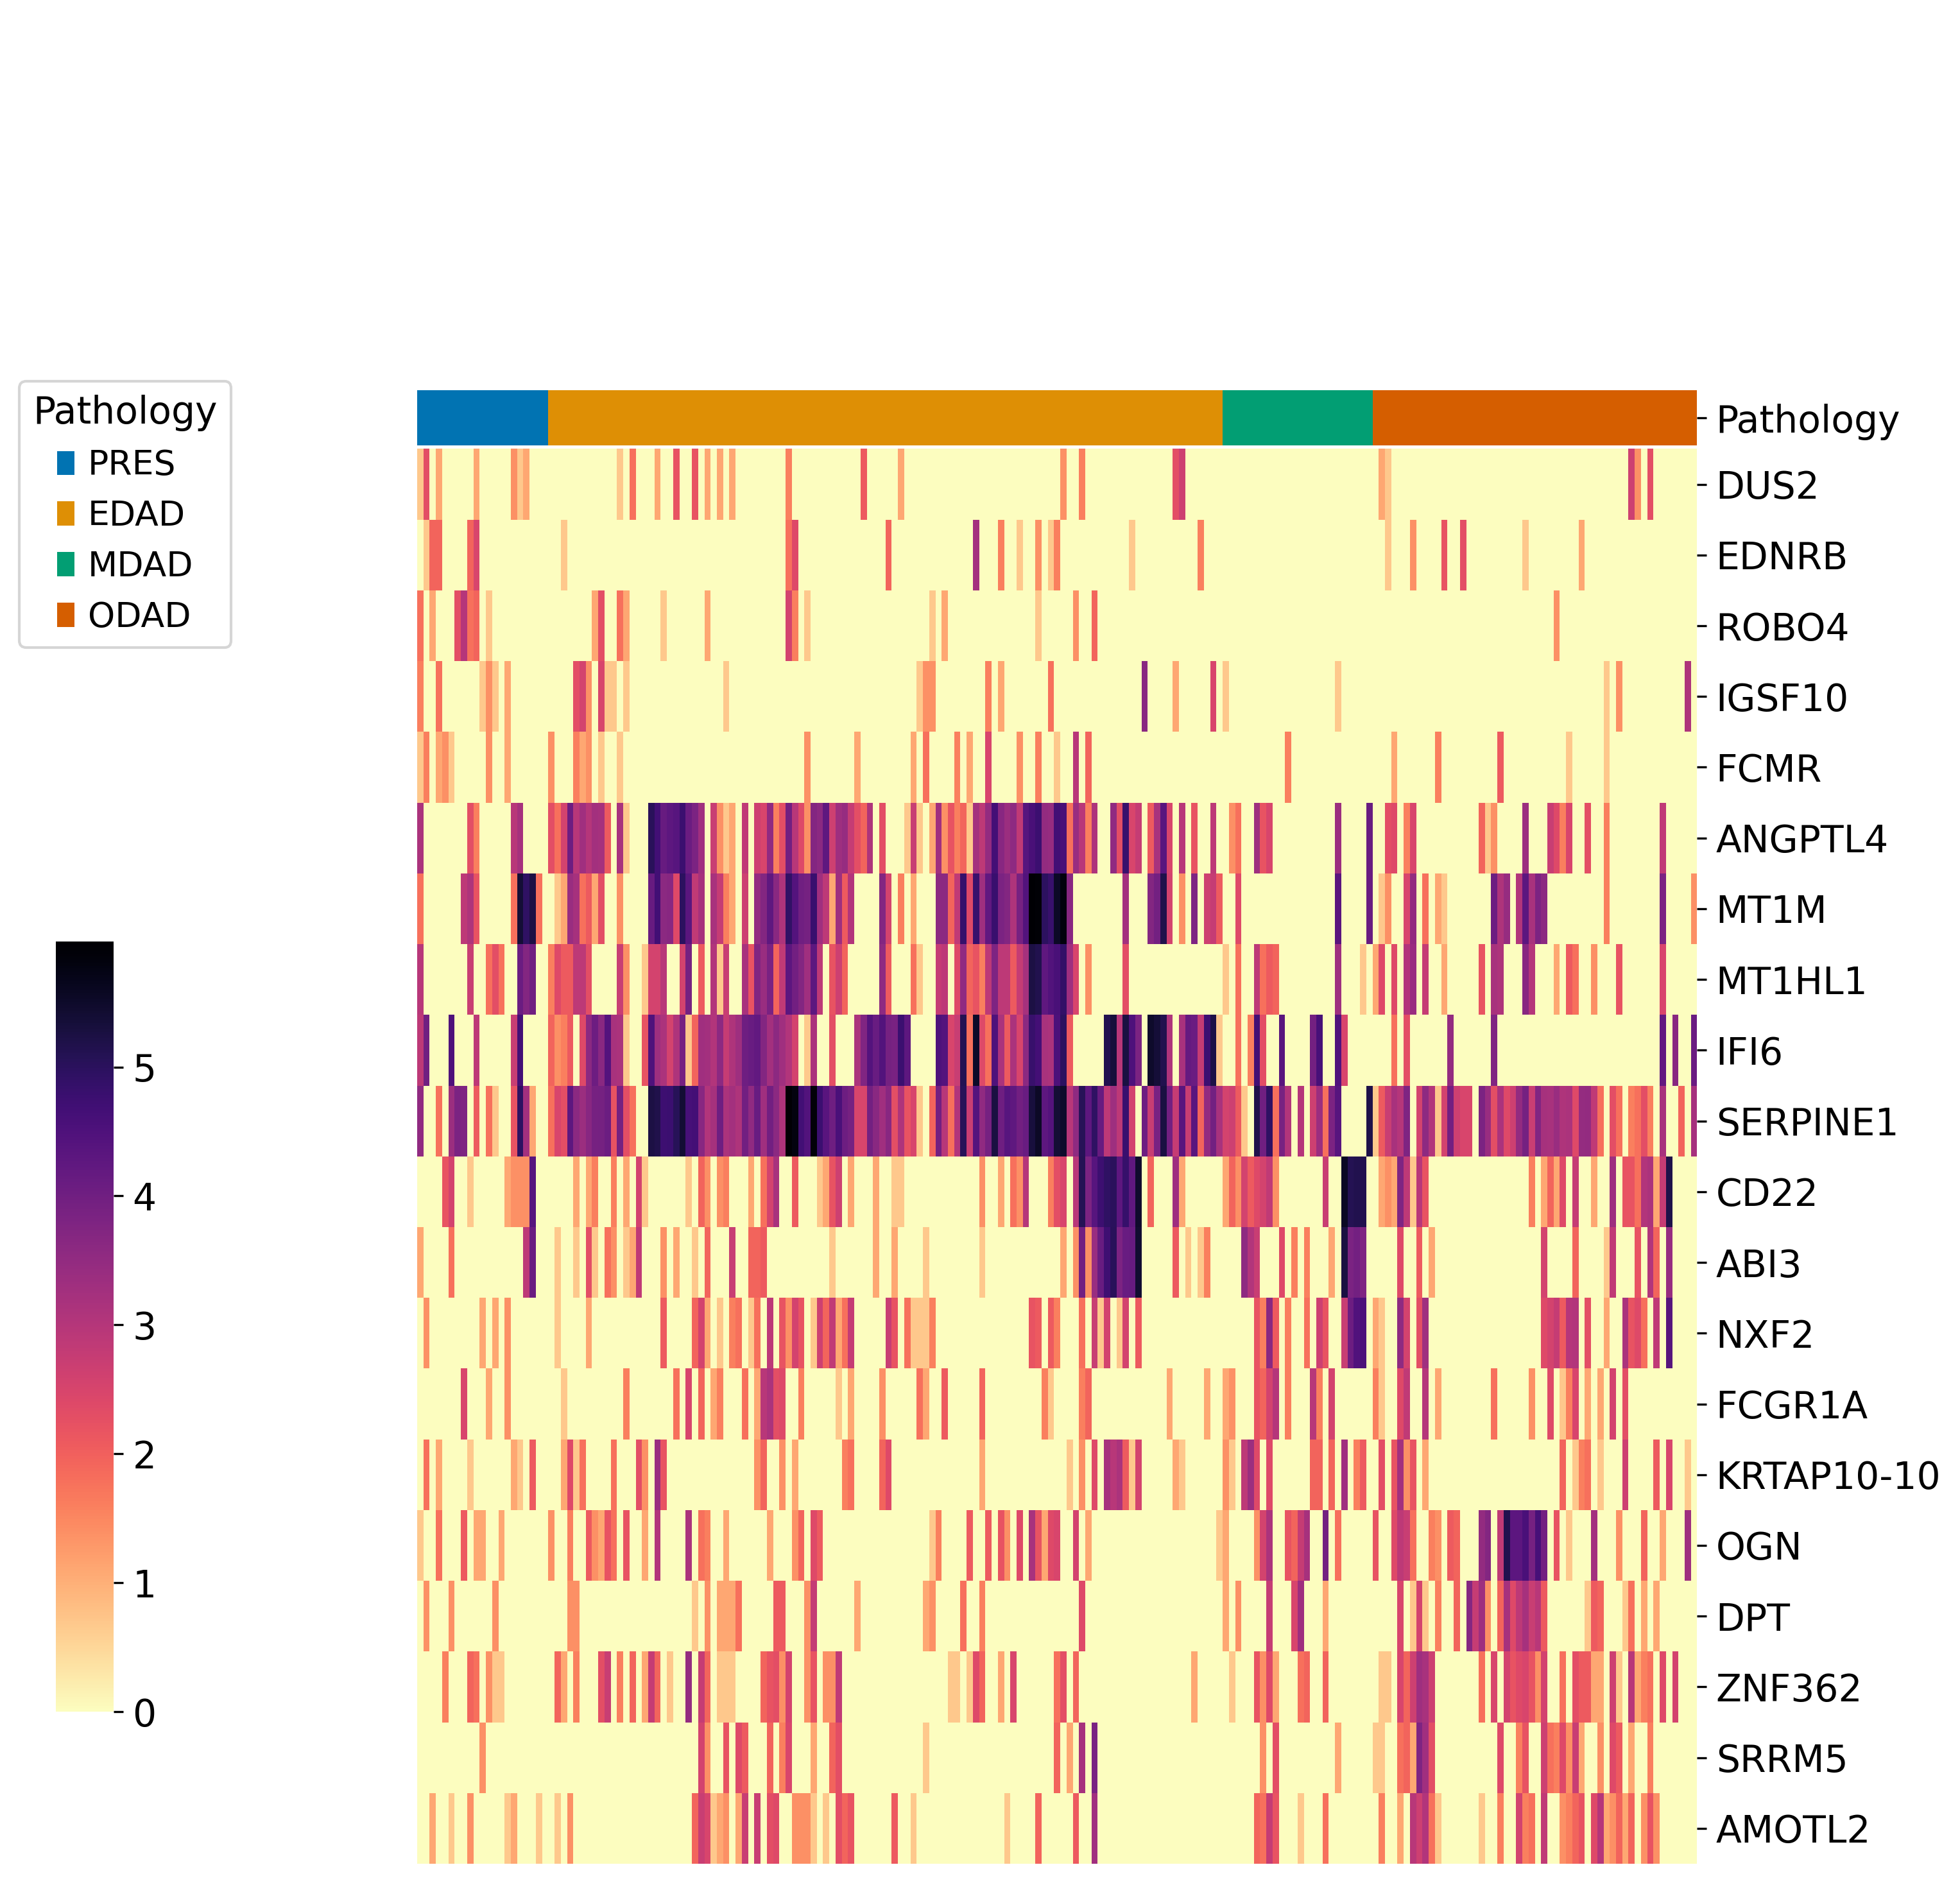

In [10]:
colours=sns.color_palette('colorblind', 4)
lut_clust = dict(zip(['PRES', 'EDAD', 'MDAD', 'ODAD'], colours))

df_sampleID_to_pathology = pd.read_csv("../data/fig3_pathology_SampleID.csv", sep = ",", index_col = 0)
matrix_heatmap = pd.read_csv("../data/fig3_subset_features_countcorrected_matrix.csv", sep = ",", index_col = 0)

col_colours = df_sampleID_to_pathology['Pathology'].map(lut_clust)

handles = [Patch(facecolor=lut_clust[name]) for name in lut_clust] 

feature_selected_to_plot = [
    "DUS2", "EDNRB", "ROBO4", "IGSF10", "FCMR",
#     "IL1RL1", "NOVA1", "ALX3", "CD55", "DHCR24",
    "ANGPTL4", "MT1M", "MT1HL1", "IFI6", #"PTX3",
    "SERPINE1", 
    "CD22", "ABI3", "NXF2", "FCGR1A", "KRTAP10-10",
    
    "OGN","DPT","ZNF362",  "SRRM5",  "AMOTL2"
]
g = sns.clustermap(matrix_heatmap.loc[feature_selected_to_plot], col_cluster = False, row_cluster = False, 
                   figsize = (10,10), cmap = "magma_r",
                   xticklabels = False, col_colors = col_colours,
#                    cbar_kws={'label': 'log expression'}
                  )
g.ax_cbar.set_position((0, 0.1, .03, .4))
plt.legend(handles, lut_clust, title='Pathology',
           bbox_to_anchor=(0.1, 0.8), bbox_transform=plt.gcf().transFigure)

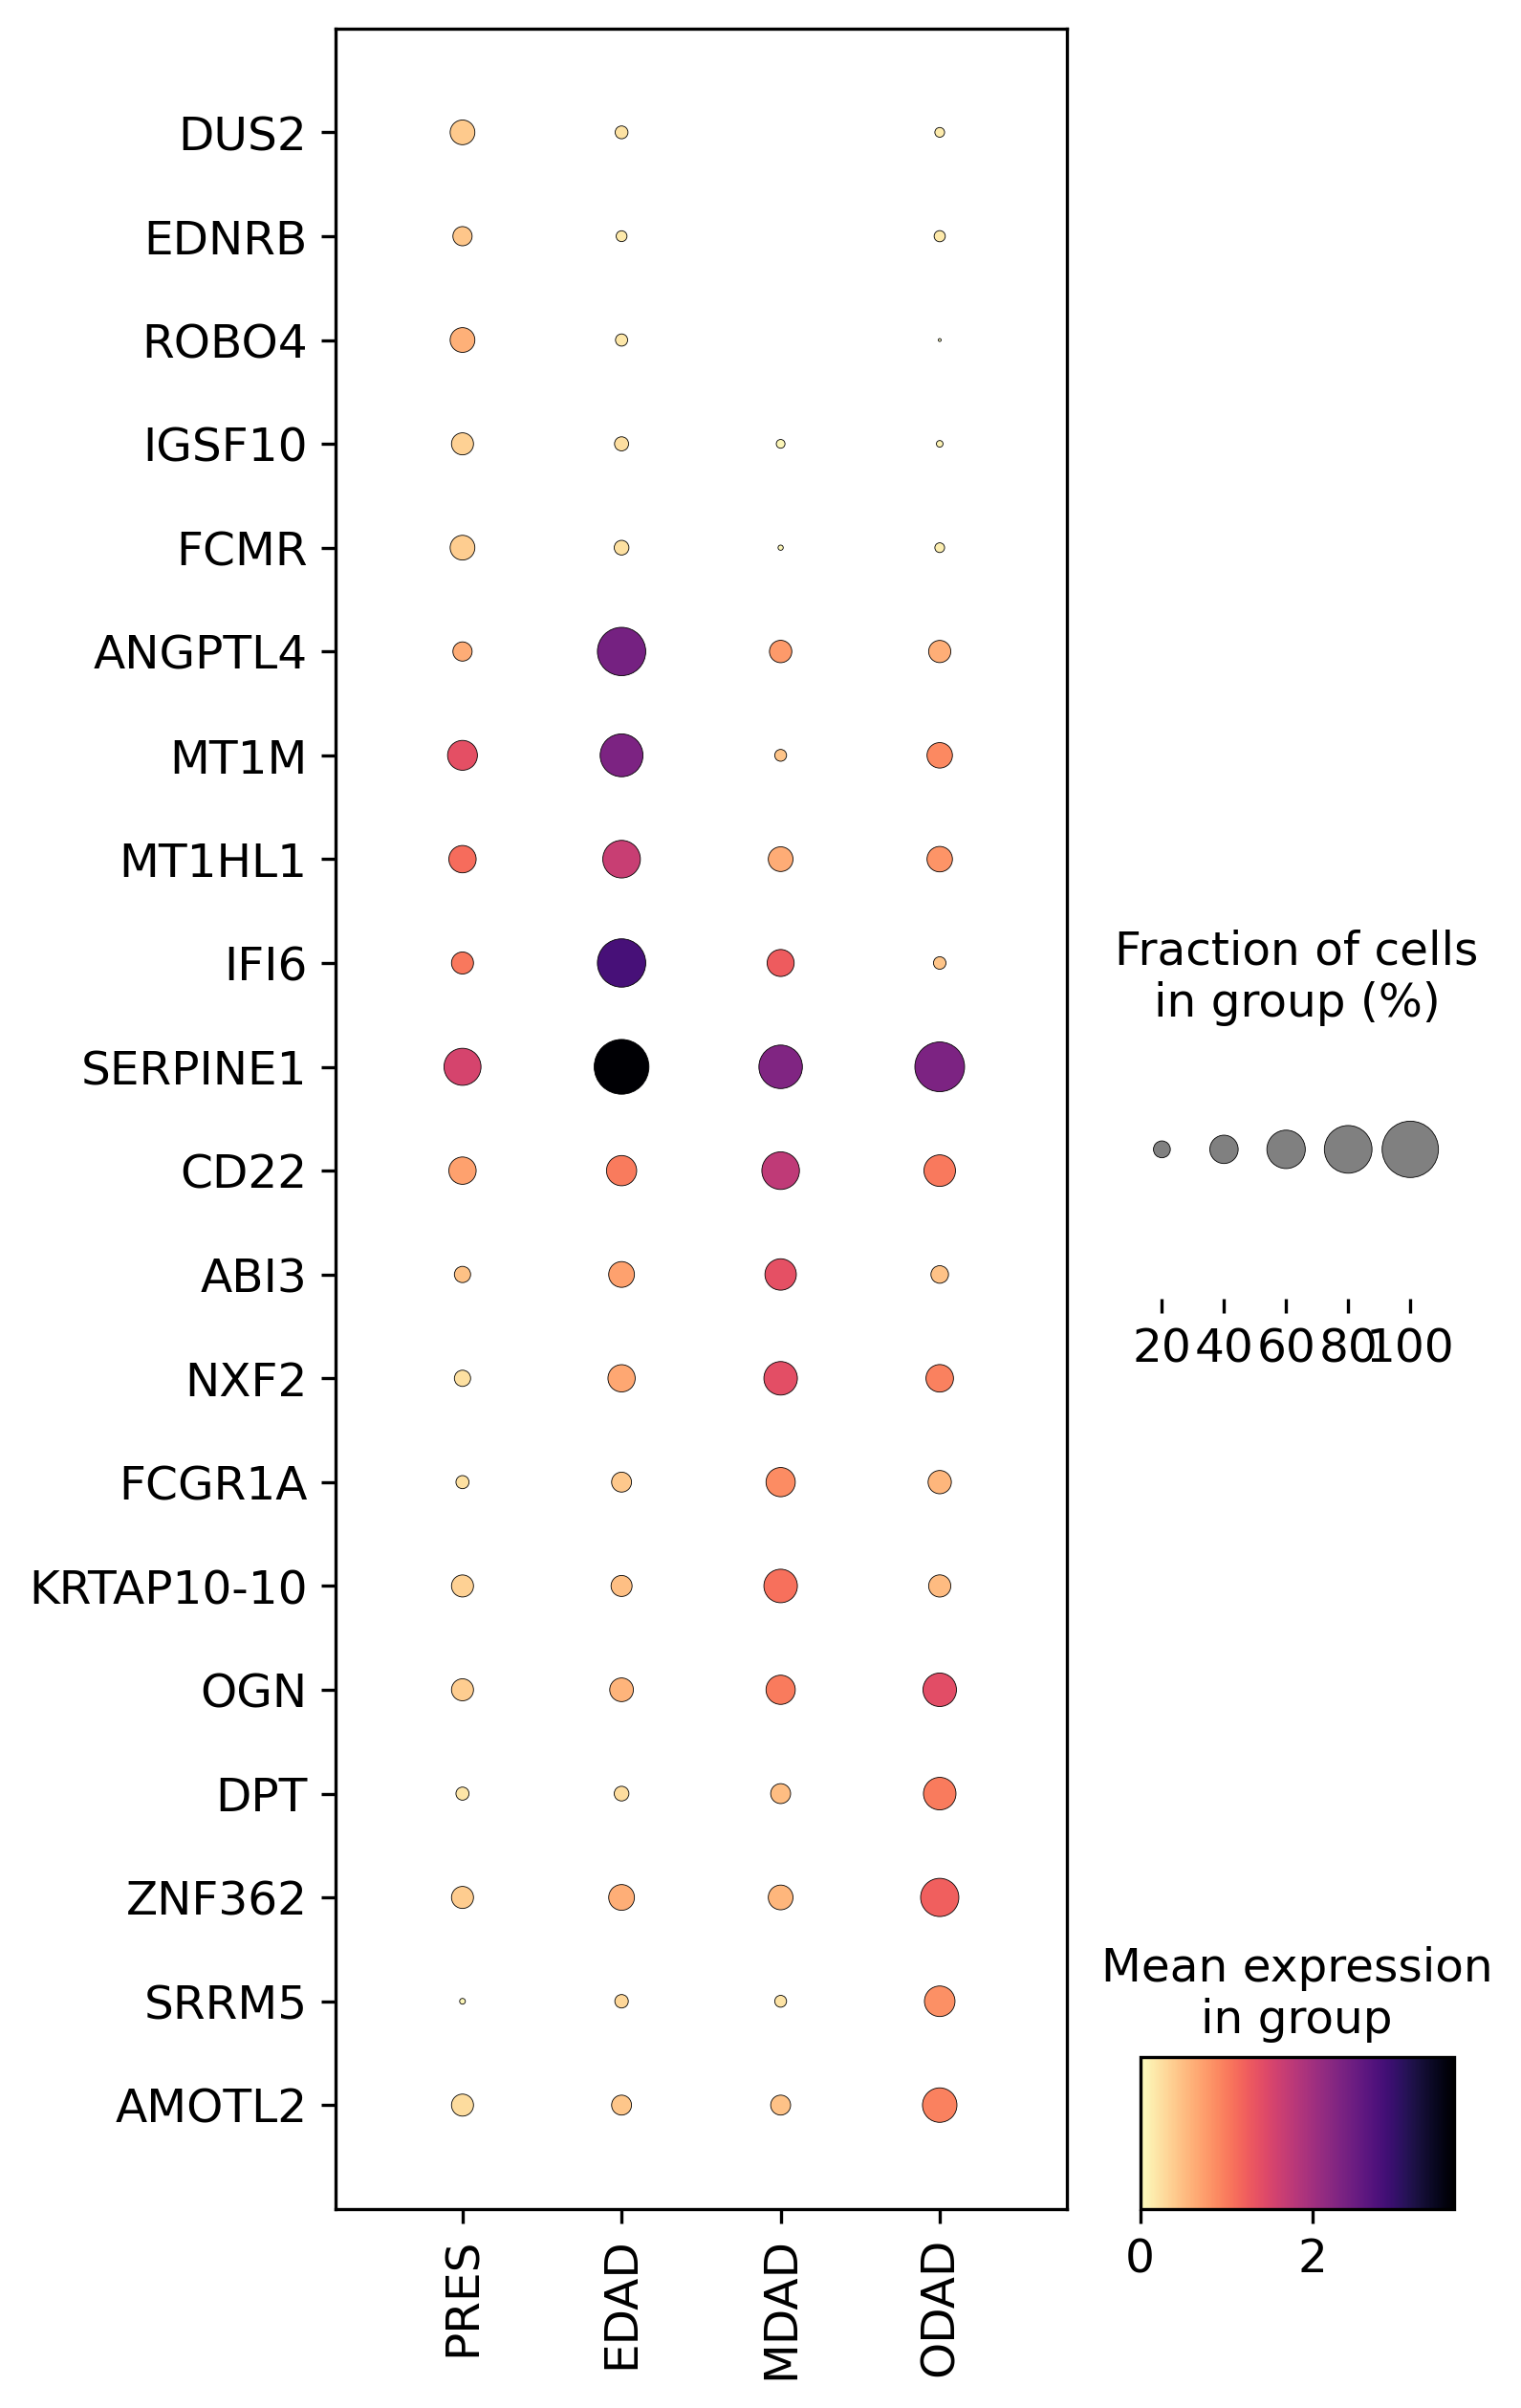

In [11]:
sc.pl.dotplot(adata=sp_adata, var_names = feature_selected_to_plot,
              groupby="Pathology", categories_order = ["PRES", "EDAD", "MDAD", "ODAD"], swap_axes=True,
              dendrogram=False, figsize=[5, 10], log = True, layer = "X_cc_corrected", 
              mean_only_expressed = False,
              cmap='magma_r')